In [2]:
%load_ext autoreload
%autoreload 2

# Noiseless

## Simulation settings

In [3]:
from utils.hexec import create_estimator_options
from utils.hexec import ExecDB
import numpy as np

L_arr = [6, 8, 10]
# L_arr = [16]
L_arr = [4]
J_arr = np.linspace(0, 5, 2)
h_arr = np.linspace(0, 5, 2)
lamb_arr = [1]
g_arr = [None]

x_basis = False

particle_pair_left_positions = [L//2 - 1 for L in L_arr]
particle_pair_length = 1

final_time = 8
steps = 35

shots = [50000]

execution_database = "z2_chain_jobs_postselection.json"
jobs_result_folder = execution_database.split(".")[0] + "/"
job_db = ExecDB(execution_database)

circ_folder_path = "Circuits/"

## Circuit generation & observables

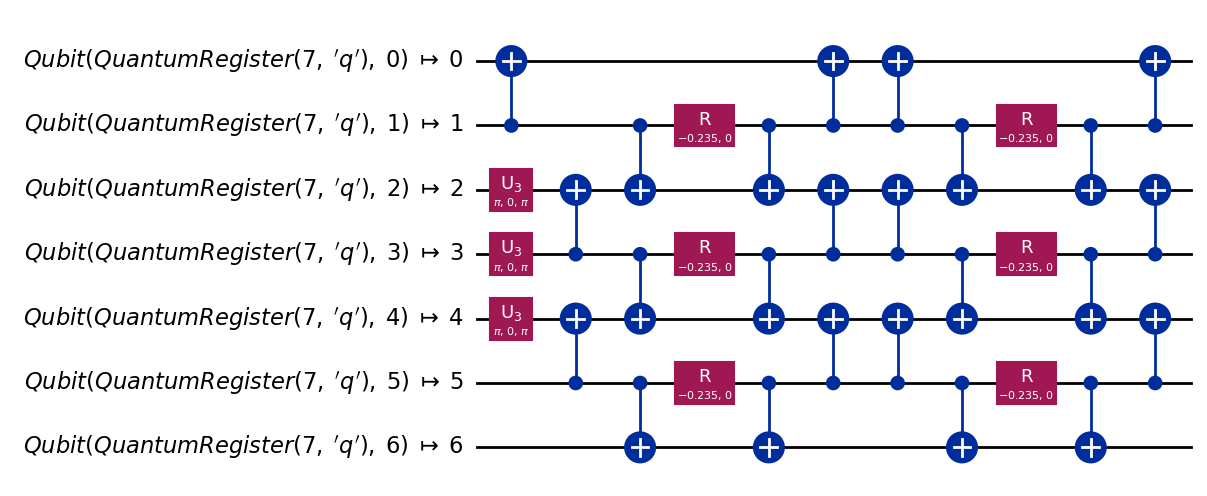

In [5]:
from z2chain.circs import erradj_particle_pair_quench_simulation_circuits
from z2chain.operators import local_pauli_x, local_pauli_z
from utils.circs import generate_and_save_circs
from qiskit_aer import AerSimulator
from itertools import product
from functools import partial
import numpy as np
import os

optimization_level = 2

circuits = [] # circuits[L][Jhλg][t]
observable_generating_funcs = [] #observable_generating_funcs[L][i]
postselection_operators_funcs = []

estimator_options = [{
    "default_precision": 1e-5
}]

simulator_options = [{
    "method": "matrix_product_state",
    "matrix_product_state_max_bond_dimension": 256,
    "matrix_product_state_truncation_threshold": 1e-10
}]

backend = AerSimulator(**simulator_options[0])

eplg_absolute = 2e-3

for L, pp_ps in zip(L_arr, particle_pair_left_positions):
    this_circuits = []
    for Ji, hi, lambi, gi in product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr))):
        circuit_filepath = os.path.join(circ_folder_path, f"z2chain_quench_circs_simulation_maxt_{final_time}_steps_{steps}_L_{L}_J_{J_arr[Ji]:.04f}_h_{h_arr[hi]:.04f}_lamb_{lamb_arr[lambi]:.04f}_g_{g_arr[gi]}_pp_{pp_ps}_pl_{particle_pair_length}_xbasis_{x_basis}.qpy")
        qubits_inds = np.arange(2*L-1).tolist()
        circs_func_args = (L, J_arr[Ji], h_arr[hi], lamb_arr[lambi], pp_ps, particle_pair_length, final_time, steps, backend, optimization_level, eplg_absolute, g_arr[gi], qubits_inds, x_basis)
        circuit = generate_and_save_circs(circuit_filepath, erradj_particle_pair_quench_simulation_circuits, *circs_func_args)
        this_circuits.append(circuit)
    circuits.append(this_circuits)

circuits[0][0][1].draw(output="mpl", idle_wires=False)

## Simulation

In [10]:
from utils.plotting import load_site_gauge_observable_matrix, save_site_gauge_observable_matrix, convert_jobs_to_site_gauge_matrix
from utils.hexec import execute_estimator_batch
from utils.sexec import execute_simulation_estimator_batch

jobs = [] # jobs[L][opts][Jhλg][t]

for i, L in enumerate(L_arr):
    this_L_jobs = []
    for estimator_opt, simulator_opt in zip(estimator_options, simulator_options):
        this_opts_jobs = []
        for Ji, hi, lambi, gi in product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr))):
            filepath = f"Results/tncirc_z2pairquench_maxt_{final_time}_steps_{steps}_L_{L}_J_{J_arr[Ji]:.04f}_h_{h_arr[hi]:.04f}_lamb_{lamb_arr[lambi]:.04f}_g_{g_arr[gi]}_pp_{particle_pair_left_positions[i]}_pl_{particle_pair_length}_xbasis_{x_basis}_bd_{simulator_opt["matrix_product_state_max_bond_dimension"]}_prec_{estimator_opt['default_precision']}.txt"
            if os.path.exists(filepath):
                this_jobs = load_site_gauge_observable_matrix(filepath)
            else:
                observable_generating_funcs = [partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)]
                this_jobs = execute_simulation_estimator_batch(simulator_opt, estimator_opt, circuits[i][Ji], observable_generating_funcs)
                this_jobs = convert_jobs_to_site_gauge_matrix(this_jobs)
                save_site_gauge_observable_matrix(this_jobs, filepath)
            this_opts_jobs.append(this_jobs)
        this_L_jobs.append(this_opts_jobs)
    jobs.append(this_L_jobs)

## Plots

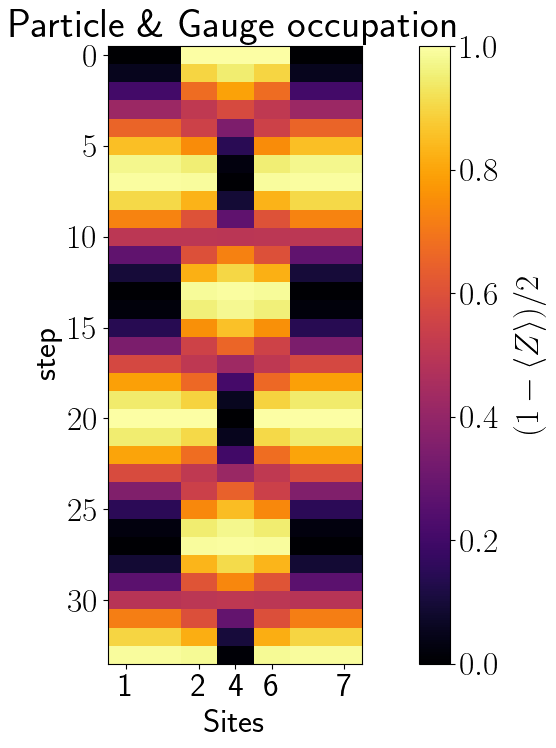

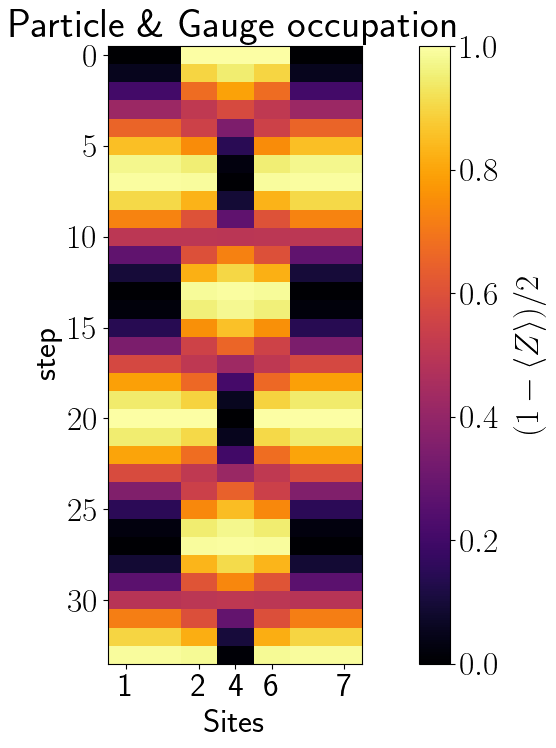

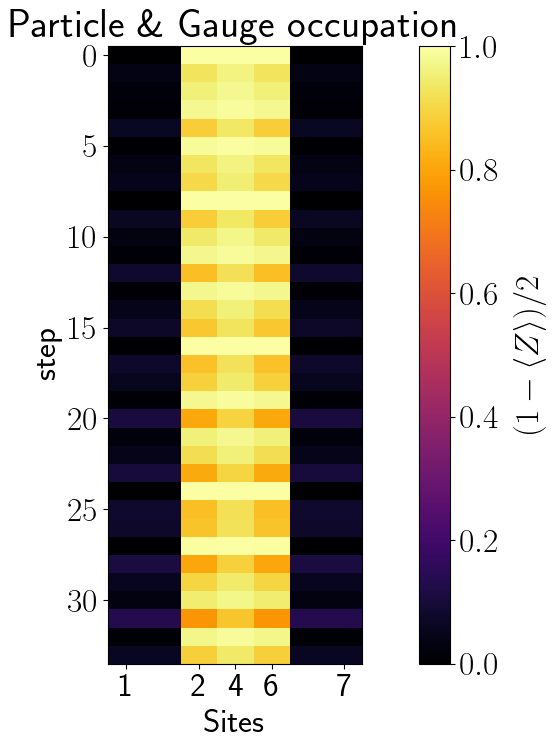

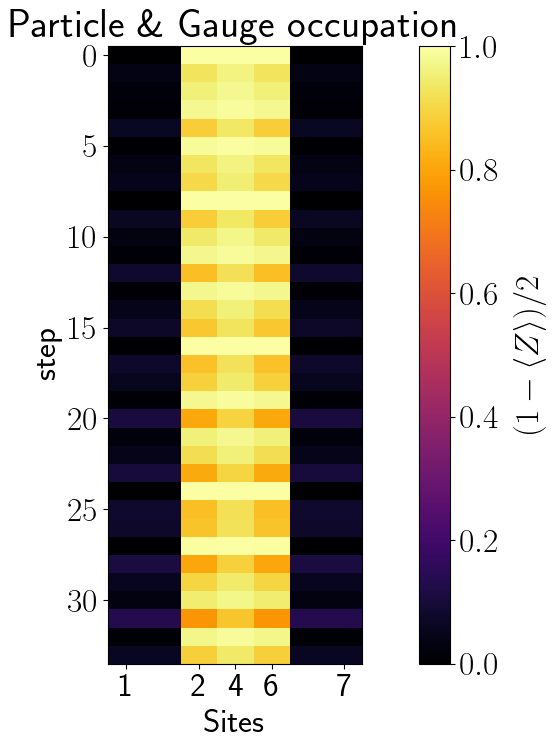

In [11]:
from z2chain.plotting import x_t_plot

for i, L in enumerate(L_arr):
    for j, (estimator_opt, simulator_opt) in enumerate(zip(estimator_options, simulator_options)):
        for Ji, hi, lambi, gi in product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr))):
            job_ind = gi + lambi*len(g_arr) + hi*len(g_arr)*len(lamb_arr) + Ji*len(g_arr)*len(lamb_arr)*len(h_arr)
            x_t_plot(jobs[i][j][job_ind], filepath=f"Plots/tncirc_z2pairquench_maxt_{final_time}_steps_{steps}_L_{L}_J_{J_arr[Ji]:.04f}_h_{h_arr[hi]:.04f}_lamb_{lamb_arr[lambi]:.04f}_g_{g_arr[gi]}_pp_{particle_pair_left_positions[i]}_pl_{particle_pair_length}_xbasis_{x_basis}_bd_{simulator_opt["matrix_product_state_max_bond_dimension"]}_prec_{estimator_opt['default_precision']}.png")

# Noisy

## Noise model

In [12]:
from fradm.tokens import ibm_token, group_instance2
# from cobos.tokens import ibm_token, group_instance2
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel

device = "ibm_fez"

service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token, instance=group_instance2)
backend = service.backend(device)

noise_model = NoiseModel.from_backend(backend)

## Circuit generation and observables

In [13]:
from z2chain.circs import erradj_particle_pair_quench_simulation_circuits
from utils.circs import generate_and_save_circs, remove_idle_qwires
from z2chain.operators import local_pauli_x, local_pauli_z
from functools import partial
import numpy as np
import os

optimization_level = 2

circuits = [] # circuits[L][t]
observable_generating_funcs = [] #observable_generating_funcs[L][i]
postselection_operators_funcs = []

estimator_options = [{
    "default_precision": 1e-5
}]

simulator_options = [{
    "method": "density_matrix",
    "noise_model": noise_model
}]

eplg_absolute = 2e-3

for L, pp_ps in zip(L_arr, particle_pair_left_positions):
    this_circuits = []
    for Ji, hi, lambi, gi in product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr))):
        circuit_filepath = os.path.join(circ_folder_path, f"z2chain_quench_circs_simulation_noisy_backend_{device}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J_arr[Ji]:.04f}_h_{h_arr[hi]:.04f}_lamb_{lamb_arr[lambi]:.04f}_g_{g_arr[gi]}_pp_{pp_ps}_pl_{particle_pair_length}_xbasis_{x_basis}.qpy")
        qubits_inds = np.arange(2*L-1).tolist()
        circs_func_args = (L, J_arr[Ji], h_arr[hi], lamb_arr[lambi], pp_ps, particle_pair_length, final_time, steps, backend, optimization_level, eplg_absolute, g_arr[gi], qubits_inds, x_basis)
        circuit = generate_and_save_circs(circuit_filepath, erradj_particle_pair_quench_simulation_circuits, *circs_func_args)
        this_circuits.append(circuit)
    circuits.append(this_circuits)
    
circuits[0][0][1].draw(output="mpl", idle_wires=False)

In [22]:
len(circuits[0][0])

35

## Simulation

In [23]:
from utils.plotting import load_site_gauge_observable_matrix, save_site_gauge_observable_matrix, convert_jobs_to_site_gauge_matrix
from utils.hexec import execute_estimator_batch
from utils.sexec import execute_simulation_estimator_batch

jobs = [] # jobs[L][opts][Jhλg][t]

for i, L in enumerate(L_arr):
    this_L_jobs = []
    for estimator_opt, simulator_opt in zip(estimator_options, simulator_options):
        this_opts_jobs = []
        for Ji, hi, lambi, gi in product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr))):
            filepath = f"Results/tncirc_z2pairquench_noisy_backend_{device}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J_arr[Ji]:.04f}_h_{h_arr[hi]:.04f}_lamb_{lamb_arr[lambi]:.04f}_g_{g_arr[gi]}_pp_{pp_ps}_pl_{particle_pair_length}_xbasis_{x_basis}.txt"
            if os.path.exists(filepath):
                this_jobs = load_site_gauge_observable_matrix(filepath)
            else:
                observable_generating_funcs = [partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)]
                no_idle_circuits = [circuits[i][Ji][0]]
                no_idle_circuits = no_idle_circuits + [remove_idle_qwires(circuit) for circuit in circuits[i][Ji][1:]]
                this_jobs = execute_simulation_estimator_batch(simulator_opt, estimator_opt, no_idle_circuits, observable_generating_funcs)
                this_jobs = convert_jobs_to_site_gauge_matrix(this_jobs)
                save_site_gauge_observable_matrix(this_jobs, filepath)
        this_L_jobs.append(this_opts_jobs)
    jobs.append(this_L_jobs)

5     | fbd080e6-4800-4c47-8bab-866aa4fa68fc


ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-18787 using the density_matrix simulator. Required memory: 18446744073709551615M, max memory: 262144M


6     | a470d059-58a5-4d4c-8f22-acb8ba23a9d7


ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-18798 using the density_matrix simulator. Required memory: 18446744073709551615M, max memory: 262144M


7     | 141fc4f9-6afa-4c32-8de0-0830243bd0f6


ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-18809 using the density_matrix simulator. Required memory: 18446744073709551615M, max memory: 262144M


8     | 6a291711-2b1c-45d9-9e40-2c70c5e83518


ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-18820 using the density_matrix simulator. Required memory: 18446744073709551615M, max memory: 262144M


9     | a1caf393-a708-4ac0-83d2-0565a0658a2e
10    | a0b219cf-b5fb-4e63-b8b7-67d1507fca72


ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-18831 using the density_matrix simulator. Required memory: 18446744073709551615M, max memory: 262144M


: 

: 

## Plots

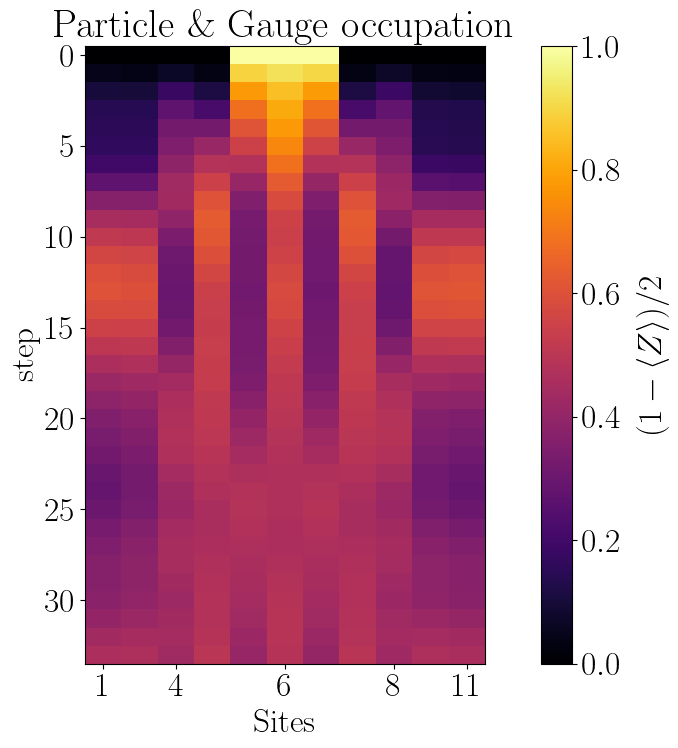

In [10]:
from z2chain.plotting import x_t_plot

for i, L in enumerate(L_arr):
    for j, (estimator_opt, simulator_opt) in enumerate(zip(estimator_options, simulator_options)):
        for Ji, hi, lambi, gi in product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr))):
            job_ind = gi + lambi*len(g_arr) + hi*len(g_arr)*len(lamb_arr) + Ji*len(g_arr)*len(lamb_arr)*len(h_arr)
            x_t_plot(jobs[i][j][job_ind], filepath=f"Plots/tncirc_z2pairquench_noisy_backend_{device}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J_arr[Ji]:.04f}_h_{h_arr[hi]:.04f}_lamb_{lamb_arr[lambi]:.04f}_g_{g_arr[gi]}_pp_{pp_ps}_pl_{particle_pair_length}_xbasis_{x_basis}.png")

# ODR mitigation - Noiseless

## Simulation settings

In [26]:
from utils.hexec import create_estimator_options
from utils.hexec import ExecDB
import numpy as np

L_arr = [6, 8, 10]
g_arr = [None]
J_arr = [0]
h_arr = [0]
lamb_arr = [1]

x_basis = False
barriers = True

final_time = 8
steps = 35

shots = [50000]

execution_database = "z2_chain_jobs_postselection_odr.json"
jobs_result_folder = execution_database.split(".")[0] + "/"
job_db = ExecDB(execution_database)

circ_folder_path = "Circuits/"

## Circuit generation & observables

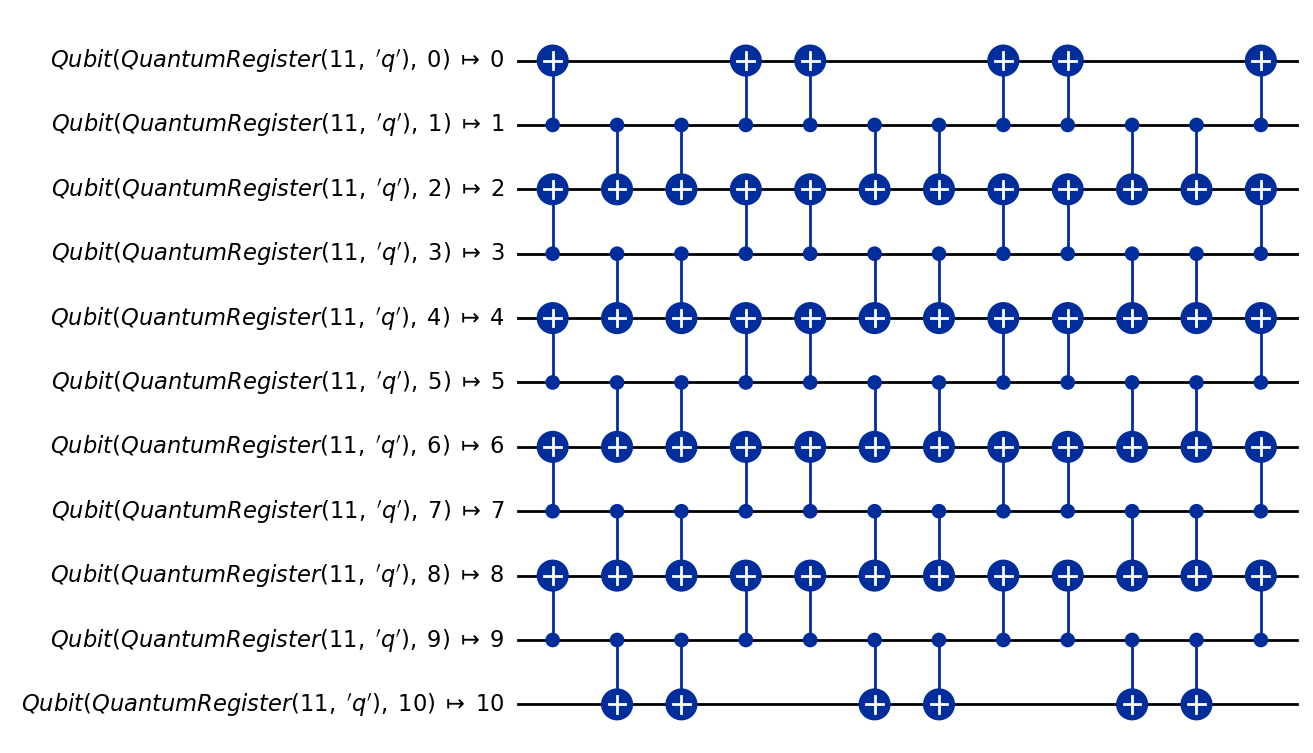

In [50]:
from z2chain.circs import odr_calibration_circuits
from z2chain.operators import local_pauli_x, local_pauli_z
from utils.circs import generate_and_save_circs
from qiskit_aer import AerSimulator
from itertools import product
from functools import partial
import numpy as np
import os

optimization_level = 2

circuits = [] # circuits[L][Jhλg][t]
observable_generating_funcs = [] #observable_generating_funcs[L][i]
postselection_operators_funcs = []

estimator_options = [{
    "default_precision": 1e-5
}]

simulator_options = [{
    "method": "matrix_product_state",
    "matrix_product_state_max_bond_dimension": 256,
    "matrix_product_state_truncation_threshold": 1e-10
}]

backend = AerSimulator(**simulator_options[0])

eplg_absolute = 2e-3

for L in L_arr:
    this_circuits = []
    for Ji, hi, lambi, gi in product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr))):
        circuit_filepath = os.path.join(circ_folder_path, f"z2chain_quench_circs_simulation_maxt_{final_time}_steps_{steps}_L_{L}_J_{J_arr[Ji]:.04f}_h_{h_arr[hi]:.04f}_lamb_{lamb_arr[lambi]:.04f}_g_{g_arr[gi]}_xbasis_{x_basis}.qpy")
        qubits_inds = np.arange(2*L-1).tolist()
        circs_func_args = (L, final_time, steps, backend, eplg_absolute, g_arr[gi], qubits_inds, x_basis, barriers)
        circuit = generate_and_save_circs(circuit_filepath, odr_calibration_circuits, *circs_func_args)
    #     this_circuits.append(circuit)
    # circuits.append(this_circuits)
    circuits.append(circuit)

circuits[0][2].draw(output="mpl", idle_wires=False)
# circuits[0][0][2].draw(output="mpl", idle_wires=False)

## Simulation

In [51]:
from utils.plotting import load_site_gauge_observable_matrix, save_site_gauge_observable_matrix, convert_jobs_to_site_gauge_matrix
from utils.hexec import execute_estimator_batch
from utils.sexec import execute_simulation_estimator_batch

jobs = [] # jobs[L][opts][Jhλg][t]

for i, L in enumerate(L_arr):
    this_L_jobs = []
    for estimator_opt, simulator_opt in zip(estimator_options, simulator_options):
        this_opts_jobs = []
        for Ji, hi, lambi, gi in product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr))):
            filepath = f"Results/tnodrcirc_z2pairquench_maxt_{final_time}_steps_{steps}_L_{L}_J_{J_arr[Ji]:.04f}_h_{h_arr[hi]:.04f}_lamb_{lamb_arr[lambi]:.04f}_g_{g_arr[gi]}_xbasis_{x_basis}_bd_{simulator_opt["matrix_product_state_max_bond_dimension"]}_prec_{estimator_opt['default_precision']}.txt"
            if os.path.exists(filepath):
                this_jobs = load_site_gauge_observable_matrix(filepath)
            else:
                observable_generating_funcs = [partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)]
                this_jobs = execute_simulation_estimator_batch(simulator_opt, estimator_opt, circuits[i], observable_generating_funcs)
                this_jobs = convert_jobs_to_site_gauge_matrix(this_jobs)
                save_site_gauge_observable_matrix(this_jobs, filepath)
            this_opts_jobs.append(this_jobs)
        this_L_jobs.append(this_opts_jobs)
    jobs.append(this_L_jobs)

## Plots

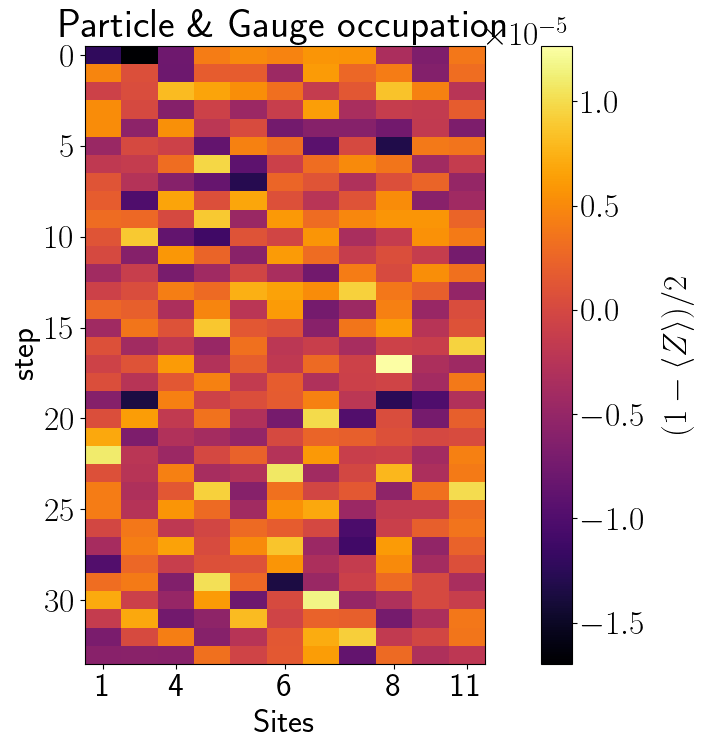

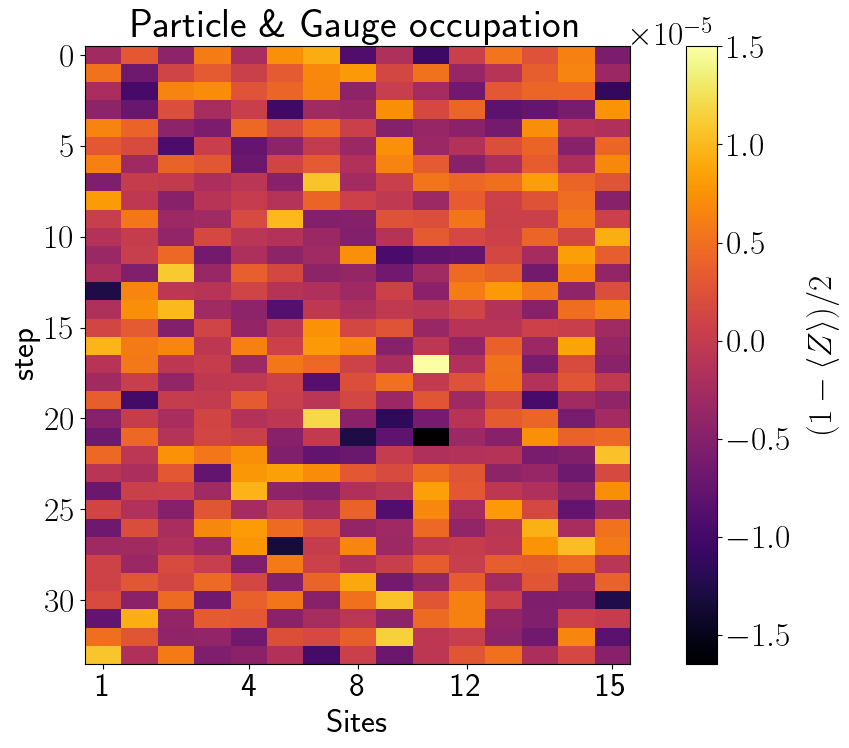

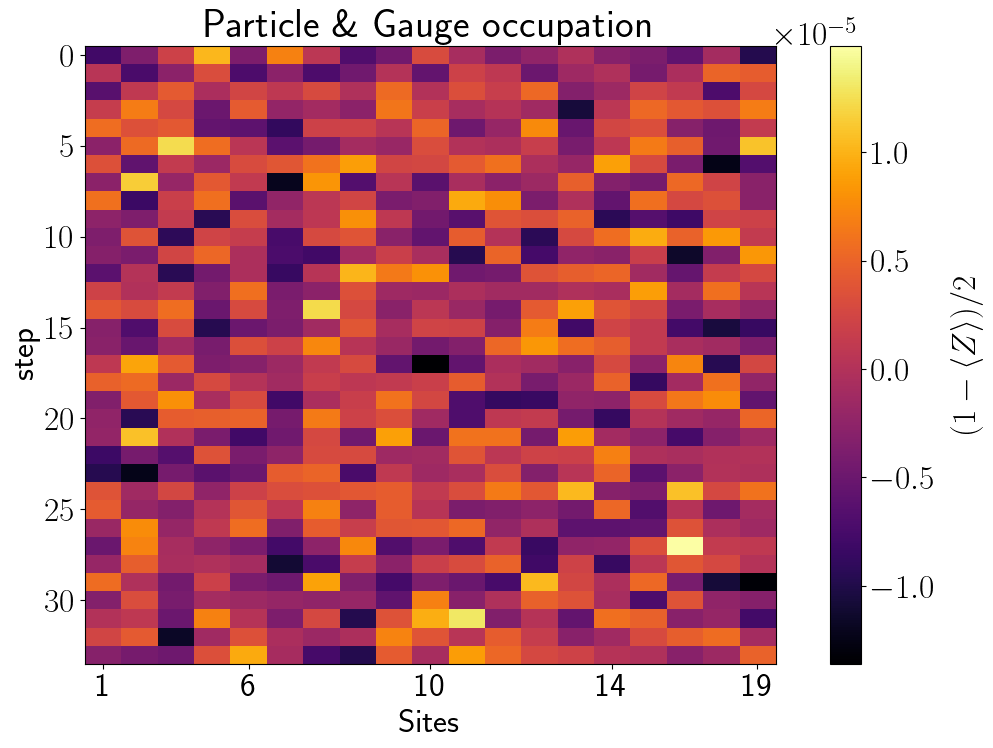

In [53]:
from z2chain.plotting import x_t_plot

for i, L in enumerate(L_arr):
    for j, (estimator_opt, simulator_opt) in enumerate(zip(estimator_options, simulator_options)):
        for Ji, hi, lambi, gi in product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr))):
            job_ind = gi + lambi*len(g_arr) + hi*len(g_arr)*len(lamb_arr) + Ji*len(g_arr)*len(lamb_arr)*len(h_arr)
            x_t_plot(jobs[i][j][job_ind], filepath=f"Plots/tnodrcirc_z2pairquench_maxt_{final_time}_steps_{steps}_L_{L}_J_{J_arr[Ji]:.04f}_h_{h_arr[hi]:.04f}_lamb_{lamb_arr[lambi]:.04f}_g_{g_arr[gi]}_xbasis_{x_basis}_bd_{simulator_opt["matrix_product_state_max_bond_dimension"]}_prec_{estimator_opt['default_precision']}.png")

## Noise Model

In [2]:
from fradm.tokens import ibm_token, group_instance2
# from cobos.tokens import ibm_token, group_instance2
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel

device = "ibm_fez"

service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token, instance=group_instance2)
backend = service.backend(device)

noise_model = NoiseModel.from_backend(backend)

In [7]:
from utils.hexec import create_estimator_options
from utils.hexec import ExecDB
import numpy as np

L_arr = [6, 8, 10]
L_arr = [6]
J_arr = [0]
h_arr = [0]
lamb_arr = [1]
g_arr = [None]

x_basis = False

particle_pair_left_positions = [L//2 - 1 for L in L_arr]
particle_pair_length = 1

final_time = 8
steps = 35

shots = [50000]

execution_database = "odrcirc_jobs_postselection.json"
jobs_result_folder = execution_database.split(".")[0] + "/"
job_db = ExecDB(execution_database)

circ_folder_path = "Circuits/"

## Circuit generation & observables

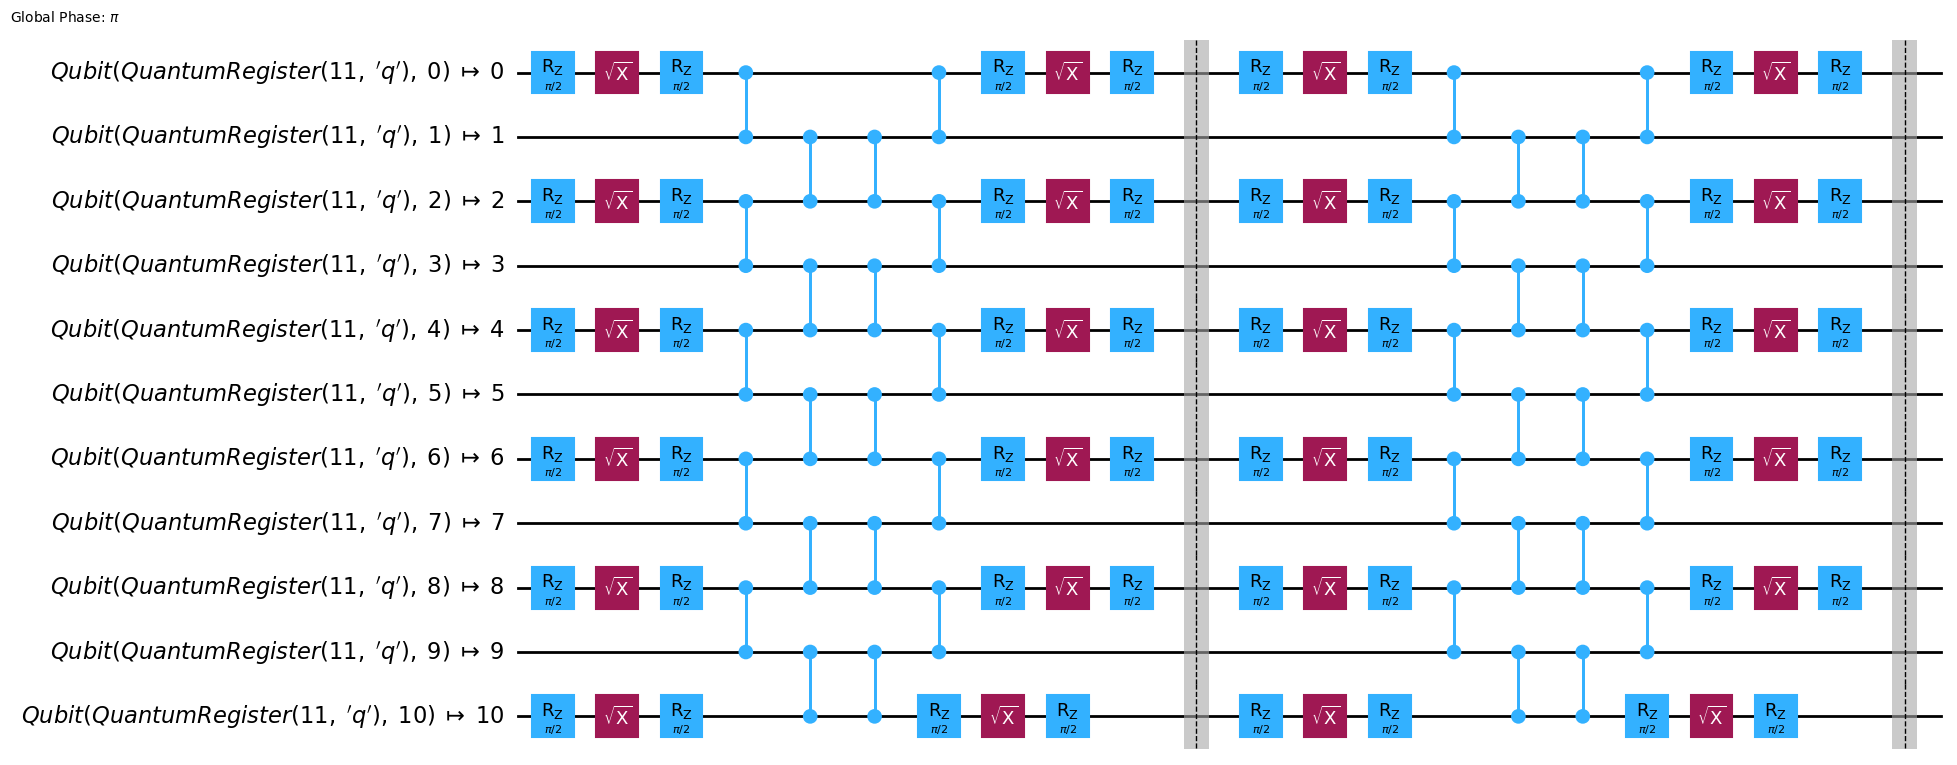

In [8]:
from z2chain.circs import odr_calibration_circuits
from utils.circs import generate_and_save_circs, remove_idle_qwires
from z2chain.operators import local_pauli_x, local_pauli_z
from itertools import product
from functools import partial
import numpy as np
import os

optimization_level = 2

circuits = [] # circuits[L][t]
observable_generating_funcs = [] #observable_generating_funcs[L][i]
postselection_operators_funcs = []

estimator_options = [{
    "default_precision": 1e-5
}]

simulator_options = [{
    "method": "density_matrix",
    "noise_model": noise_model
}]

eplg_absolute = 2e-3
barriers = True

for L, pp_ps in zip(L_arr, particle_pair_left_positions):
    this_circuits = []
    for Ji, hi, lambi, gi in product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr))):
        circuit_filepath = os.path.join(circ_folder_path, f"z2chain_quench_circs_simulation_noisy_backend_{device}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J_arr[Ji]:.04f}_h_{h_arr[hi]:.04f}_lamb_{lamb_arr[lambi]:.04f}_g_{g_arr[gi]}_pp_{pp_ps}_pl_{particle_pair_length}_xbasis_{x_basis}.qpy")
        qubits_inds = np.arange(2*L-1).tolist()
        circs_func_args = (L, final_time, steps, backend, eplg_absolute, g_arr[gi], qubits_inds, x_basis, barriers)
        circuit = generate_and_save_circs(circuit_filepath, odr_calibration_circuits, *circs_func_args)
        # this_circuits.append(circuit)
    # circuits.append(this_circuits)
    circuits.append(circuit)

circuits[0][1].draw(output="mpl", idle_wires=False)

## Simulation

In [ ]:
from utils.plotting import load_site_gauge_observable_matrix, save_site_gauge_observable_matrix, convert_jobs_to_site_gauge_matrix
from utils.hexec import execute_estimator_batch
from utils.sexec import execute_simulation_estimator_batch

jobs = [] # jobs[L][opts][Jhλg][t]

for i, L in enumerate(L_arr):
    this_L_jobs = []
    for estimator_opt, simulator_opt in zip(estimator_options, simulator_options):
        this_opts_jobs = []
        for Ji, hi, lambi, gi in product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr))):
            filepath = f"Results/odr_densitymatrix_z2pairquench_noisy_backend_{device}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J_arr[Ji]:.04f}_h_{h_arr[hi]:.04f}_lamb_{lamb_arr[lambi]:.04f}_g_{g_arr[gi]}_xbasis_{x_basis}.txt"
            if os.path.exists(filepath):
                this_jobs = load_site_gauge_observable_matrix(filepath)
            else:
                observable_generating_funcs = [partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)]
                no_idle_circuits = [circuits[0][0]]
                no_idle_circuits = no_idle_circuits + [remove_idle_qwires(circuit) for circuit in circuits[0][1:]]
                display(no_idle_circuits[1].draw('mpl'))
                this_jobs = execute_simulation_estimator_batch(simulator_opt, estimator_opt, no_idle_circuits, observable_generating_funcs)
                this_jobs = convert_jobs_to_site_gauge_matrix(this_jobs)
            save_site_gauge_observable_matrix(this_jobs, filepath)
            this_opts_jobs.append(this_jobs)
        this_L_jobs.append(this_opts_jobs)
    jobs.append(this_L_jobs)

## Plots

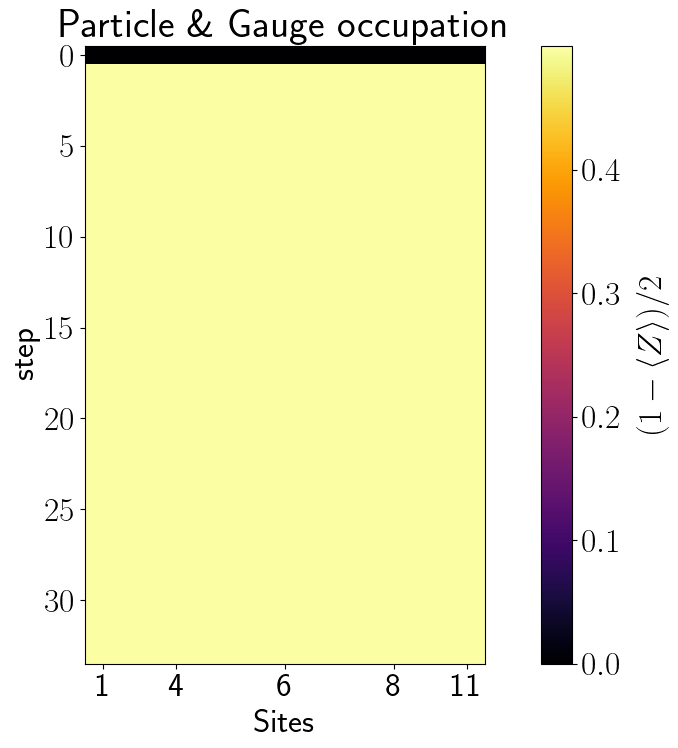

In [10]:
from z2chain.plotting import x_t_plot

for i, L in enumerate(L_arr):
    for j, (estimator_opt, simulator_opt) in enumerate(zip(estimator_options, simulator_options)):
        for Ji, hi, lambi, gi in product(range(len(J_arr)), range(len(h_arr)), range(len(lamb_arr)), range(len(g_arr))):
            job_ind = gi + lambi*len(g_arr) + hi*len(g_arr)*len(lamb_arr) + Ji*len(g_arr)*len(lamb_arr)*len(h_arr)
            x_t_plot(jobs[i][j][job_ind], filepath=f"Plots/odrcirc_z2pairquench_noisy_backend_{device}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J_arr[Ji]:.04f}_h_{h_arr[hi]:.04f}_lamb_{lamb_arr[lambi]:.04f}_g_{g_arr[gi]}_pp_{pp_ps}_pl_{particle_pair_length}_xbasis_{x_basis}.png")

## ODR correction

In [ ]:
def get_results(filepath):
    if os.path.exists(filepath):
        this_jobs = load_site_gauge_observable_matrix(filepath)

def mitigate_site_gauge_observable_matrix(fp_unmitigated, fp_odr):
    z2chain_res = get_results(fp_unmitigated)
    odr_coeff = get_results(fp_odr)
    return z2chain_res / odr_coeff

In [ ]:
filepath_z2chain = f"Results/tncirc_z2pairquench_noisy_backend_{device}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J_arr[Ji]:.04f}_h_{h_arr[hi]:.04f}_lamb_{lamb_arr[lambi]:.04f}_g_{g_arr[gi]}_pp_{pp_ps}_pl_{particle_pair_length}_xbasis_{x_basis}.txt"
filepath_odr = f"Results/odr_densitymatrix_z2pairquench_noisy_backend_{device}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J_arr[Ji]:.04f}_h_{h_arr[hi]:.04f}_lamb_{lamb_arr[lambi]:.04f}_g_{g_arr[gi]}_xbasis_{x_basis}.txt"
